In [1]:
library(rstan)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
## choose whatever is appropiate for your computing environment
## useful on laptop
cores <- parallel::detectCores()
## needed on cluster
#cores <- as.numeric(Sys.getenv("NSLOTS"))

In [3]:
options(mc.cores = cores)

In [4]:
expose_stan_functions('pkpd_mvn_approxb.stan')

In [5]:
valogit(50/100)

[1] 0

In [6]:
chains <- 4
iter <- 5000
warmup <- iter/2

___

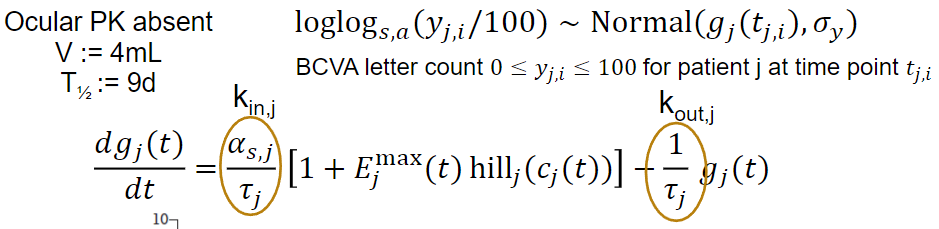

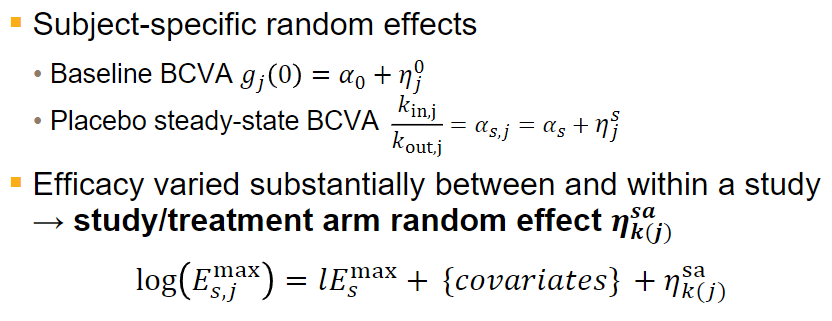

$\frac{dR_j(t)}{dt}=k^{in}_j-k^{out}_{j}[R_j(t)-E_{max_j}S_j(C_j(t))]$

$R^{SS}_j=(k^{in}_j/k^{out}_j)+E_{max_j}s_j$

Constant maximal drug effect means $S_j(t)=s_j=1$ for a patient in treatment group and o for placebo patients.
$R_j(t)=R^{ss}_j+(R_{0_j}-R^{ss}_jexp(-k^{out}_jt))$

$R_{0_j}\sim N(L\alpha_0, \sigma^2_{L\alpha_0})$
$L\alpha_0\sim N(0,2^2), \sigma_{L\alpha_0}\sim N^+(0,1^2)$

In [7]:
Lalpha_0 <- valogit(50/100)
sigma_Lalpha_0 <- 0.2
Lalpha_0

[1] 0

$L\alpha_s=\frac{\kappa^{in}_{j}}{\kappa^{out}_{j}}$ is the placebo steady state, the asymptotic value patients reach if not on treatment.

$L\alpha_s=logit(35/100)$

$L\alpha_s\sim N(-1, 2^2)$

In [8]:
Lalpha_s <- valogit(35/100)
Lalpha_s

[1] -0.6190392

$log(1/k^{out}_{j}) \sim N(l_\kappa, \sigma^2_{l_\kappa})$ detemines the patient specific time scale of the exponential change. $\kappa^{out}_j$ is a rate of change
$l_\kappa=log(10/52)$ and $l_\kappa\sim N(log(1/4), log(2)^2)$

$\sigma_{l_\kappa}\sim N^+(0, 1^2)$

In [9]:
lkappa <- log(10/52)
sigma_lkappa <- 0.5

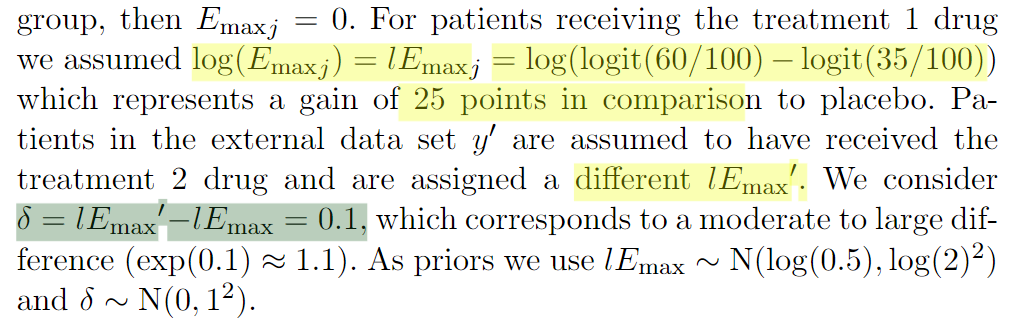

In [10]:
lEmax <- log(valogit(60/100)-Lalpha_s) # patients received treatment 1 with raw measurements data
lEmax

[1] 0.0242089

In [11]:
sigma_y <- 5/100 # measurement error

___

In [12]:
## from the first group the first half is placebo, the rest is on
## treatment 1
J <- 100

J_prime <- 100

In [13]:
## let's say we cover a year and measure monthly
x <- seq(0, 52, length=13) / 52
T <- 13

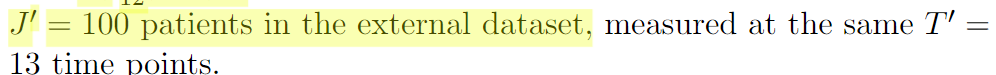

In [14]:
## for simplicity assume the prime data set is at the same time-points
x_prime <- seq(0, 52, length=13) / 52
T_prime <- 13

In [15]:
## number of simulations per draw of the posterior to get
## approximated log-lik weight
J_tilde <- 500

$\phi=\{\phi_1, \phi_2, \phi_3 \phi_4, \phi_5, \phi_6, \phi_7\} = \{L\alpha_0, L\alpha_s, l_\kappa, lEmax, log(\sigma_{L\alpha_0}), log(\sigma_{L\kappa}), log(\sigma_y) \}$

In [16]:
## define weakly-informative prior
## phi is ordered as:
##  phi[1] = Lalpha_0;
##  phi[2] = Lalpha_s;
##  phi[3] = lkappa;
##  phi[4] = lEmax;
##  phi[5] = log(sigma_Lalpha_0);
##  phi[6] = log(sigma_lkappa);
##  phi[7] = log(sigma_y);

$\mu_\phi$

In [17]:
mu_phi_p <- c(0, -1, log(1/4), log(0.5), 0, 0, 0)

In [18]:
K_phi <- length(mu_phi_p) # number of phis in the model

In [19]:
Sigma_phi_p <- diag(c(2, 2, log(2), log(2), 1, 1, 1)^2)

In [20]:
K <- 1
delta <- array(0.1, dim=1)
delta

[1] 0.1

In [21]:
mu_delta_p <- array(0, dim=1)
Sigma_delta_p <- matrix(1^2)

In [22]:
Sigma_delta_p

1


In [23]:
# simulated asymptotic values for each group
inv_valogit(Lalpha_s) ## placebo t=inf
inv_valogit(Lalpha_s + exp(lEmax)) ## drug=1 t=inf
inv_valogit(Lalpha_s + exp(lEmax + delta)) ## drug=2 t=inf

[1] 0.35

[1] 0.6

[1] 0.6255594

___

In [24]:
## simulate patient specific parameters
J_tot <- J + J_prime
subj_tot <- data.frame(id=1:J_tot
                      ,prime=rep(c(0,1), times=c(J, J_prime))
                      ,DRUG=0
                      ,eta_Lalpha_0=rnorm(J_tot, 0, 1)
                      ,eta_lkappa =rnorm(J_tot, 0, 1)
                   )

In [27]:
subj_tot$DRUG[(J/2+1):J] <- 1
subj_tot$DRUG[(J+1):J_tot] <- 2

In [28]:
subj_tot

id,prime,DRUG,eta_Lalpha_0,eta_lkappa
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,-1.03136920,0.33561916
2,0,0,0.79551448,0.75936092
3,0,0,-1.21702732,0.96887617
4,0,0,-0.75923460,-0.64319056
5,0,0,-0.69291579,0.94624946
6,0,0,0.52295519,1.17856717
7,0,0,0.83223628,1.08813926
8,0,0,-0.84822694,0.77807407
9,0,0,0.07667358,2.19707422


In [29]:
subj       <- subset(subj_tot, prime==0)
subj_prime <- subset(subj_tot, prime==1)

In [30]:
subj

,id,prime,DRUG,eta_Lalpha_0,eta_lkappa
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,0,-1.03136920,0.33561916
2,2,0,0,0.79551448,0.75936092
3,3,0,0,-1.21702732,0.96887617
4,4,0,0,-0.75923460,-0.64319056
5,5,0,0,-0.69291579,0.94624946
6,6,0,0,0.52295519,1.17856717
7,7,0,0,0.83223628,1.08813926
8,8,0,0,-0.84822694,0.77807407
9,9,0,0,0.07667358,2.19707422


In [31]:
subj_prime

,id,prime,DRUG,eta_Lalpha_0,eta_lkappa
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
101,101,1,2,0.253124836,0.56268127
102,102,1,2,-0.941037322,-2.27677600
103,103,1,2,1.225887708,-0.10330544
104,104,1,2,0.156052413,1.16658627
105,105,1,2,-0.352642321,0.19566943
106,106,1,2,-0.968387537,0.25998482
107,107,1,2,1.227481026,0.84927115
108,108,1,2,-0.939210083,1.18431855
109,109,1,2,0.246833768,-1.67644276


In [40]:
source("utils_baad.R") # helper functions

### applies a function over each entry of the posterior if vectorized=FALSE; for vectorized=TRUE the function is assumed to perform the simulation in a single sweep. Note that all arguments to the function are automatically deduced from it's formals and that all arguments which are not in the sims list are searched in the global environment.

#### vapply() is used to apply a function to elements of a list, vector, or data frame. Unlike sapply or lapply, it requires you to specify the expected data type for the result.

In [ ]:
asub() # subsetting
# asub(x, idx, dims = seq(along = dim(x)), drop = FALSE, ...)

In [ ]:
extract_draw <- function(sims, draw) lapply(sims, asub, idx=draw, dim=1)

In [47]:
NROW(subj[[1]])

[1] 100

In [37]:
pstream__ <- get_stream()

In [43]:
setdiff(names(formals(evaluate_model)), "seed")

[1] "x"              "DRUG"           "Lalpha_0"       "Lalpha_s"      
 [5] "lkappa"         "lEmax"          "delta"          "eta_Lalpha_0"  
 [9] "eta_lkappa"     "sigma_Lalpha_0" "sigma_lkappa"   "pstream__"

In [39]:
ysim       <- sim_posterior(subj, evaluate_model, TRUE)

In [45]:
dim(ysim)

[1] 100  13

In [48]:
ysim_prime <- sim_posterior(subj_prime, evaluate_model, TRUE)

In [49]:
dim(ysim_prime)

[1] 100  13

In [50]:
dimnames(ysim) <- list(id=1:J, k=1:T)

In [51]:
ysim

,1,2,3,4,5,6,7,8,9,10,11,12,13
1,0.4486136,0.4175360,0.3963550,0.3818915,0.3719848,0.3651791,0.3604924,0.3572590,0.3550250,0.3534800,0.3524108,0.3516704,0.3511576
2,0.5396920,0.4898718,0.4529076,0.4257364,0.4058132,0.3911956,0.3804516,0.3725383,0.3666988,0.3623825,0.3591877,0.3568205,0.3550651
3,0.4394473,0.4178969,0.4016005,0.3892655,0.3799145,0.3728138,0.3674133,0.3633004,0.3601646,0.3577714,0.3559438,0.3545471,0.3534794
4,0.4621110,0.4104633,0.3828008,0.3678899,0.3597922,0.3553714,0.3529500,0.3516213,0.3508914,0.3504902,0.3502696,0.3501483,0.3500816
5,0.4654096,0.4372661,0.4160407,0.4000402,0.3879657,0.3788390,0.3719287,0.3666883,0.3627089,0.3596837,0.3573817,0.3556288,0.3542933
6,0.5261239,0.4874956,0.4572026,0.4335915,0.4152296,0.4009519,0.3898406,0.3811825,0.3744267,0.3691484,0.3650198,0.3617871,0.3592540
7,0.5415160,0.4979456,0.4640513,0.4379057,0.4178023,0.4023522,0.3904687,0.3813159,0.3742558,0.3688022,0.3645843,0.3613186,0.3587878
8,0.4576901,0.4294716,0.4087183,0.3934511,0.3822012,0.3738949,0.3677501,0.3631967,0.3598178,0.3573079,0.3554417,0.3540533,0.3530198
9,0.5038336,0.4825090,0.4641011,0.4482461,0.4346068,0.4228808,0.4128012,0.4041357,0.3966835,0.3902720,0.3847533,0.3800006,0.3759056
10,0.4106781,0.3816378,0.3665948,0.3587377,0.3546108,0.3524361,0.3512879,0.3506811,0.3503603,0.3501906,0.3501008,0.3500534,0.3500282


In [52]:
dimnames(ysim_prime) <- list(id=(1+J):J_tot, k=1:T_prime)

In [54]:
dimnames(ysim_prime)

$id
  [1] "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111" "112"
 [13] "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123" "124"
 [25] "125" "126" "127" "128" "129" "130" "131" "132" "133" "134" "135" "136"
 [37] "137" "138" "139" "140" "141" "142" "143" "144" "145" "146" "147" "148"
 [49] "149" "150" "151" "152" "153" "154" "155" "156" "157" "158" "159" "160"
 [61] "161" "162" "163" "164" "165" "166" "167" "168" "169" "170" "171" "172"
 [73] "173" "174" "175" "176" "177" "178" "179" "180" "181" "182" "183" "184"
 [85] "185" "186" "187" "188" "189" "190" "191" "192" "193" "194" "195" "196"
 [97] "197" "198" "199" "200"

$k
 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13"

In [68]:
library(abind)
library(reshape2)
library(dplyr)
library(ggplot2)

In [62]:
M <- arrange(melt(ysim), id, k)
Mp <- arrange(melt(ysim_prime), id, k)
M$x <- x[M$k]
Mp$x<- x_prime[Mp$k]

M <- merge(rbind(M,Mp), subj_tot, by="id")

In [65]:
M

id,k,value,x,prime,DRUG,eta_Lalpha_0,eta_lkappa
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.4486136,0.00000000,0,0,-1.0313692,0.3356192
1,2,0.4175360,0.08333333,0,0,-1.0313692,0.3356192
1,3,0.3963550,0.16666667,0,0,-1.0313692,0.3356192
1,4,0.3818915,0.25000000,0,0,-1.0313692,0.3356192
1,5,0.3719848,0.33333333,0,0,-1.0313692,0.3356192
1,6,0.3651791,0.41666667,0,0,-1.0313692,0.3356192
1,7,0.3604924,0.50000000,0,0,-1.0313692,0.3356192
1,8,0.3572590,0.58333333,0,0,-1.0313692,0.3356192
1,9,0.3550250,0.66666667,0,0,-1.0313692,0.3356192


In [69]:
# ## look at the simulated means
plm <- ggplot(M, aes(x, value, group=id, colour=factor(DRUG))) +
        geom_line(alpha=0.3) +
        stat_summary(aes(group=DRUG), fun.data = "mean_cl_boot", position=position_dodge(width=0.02))


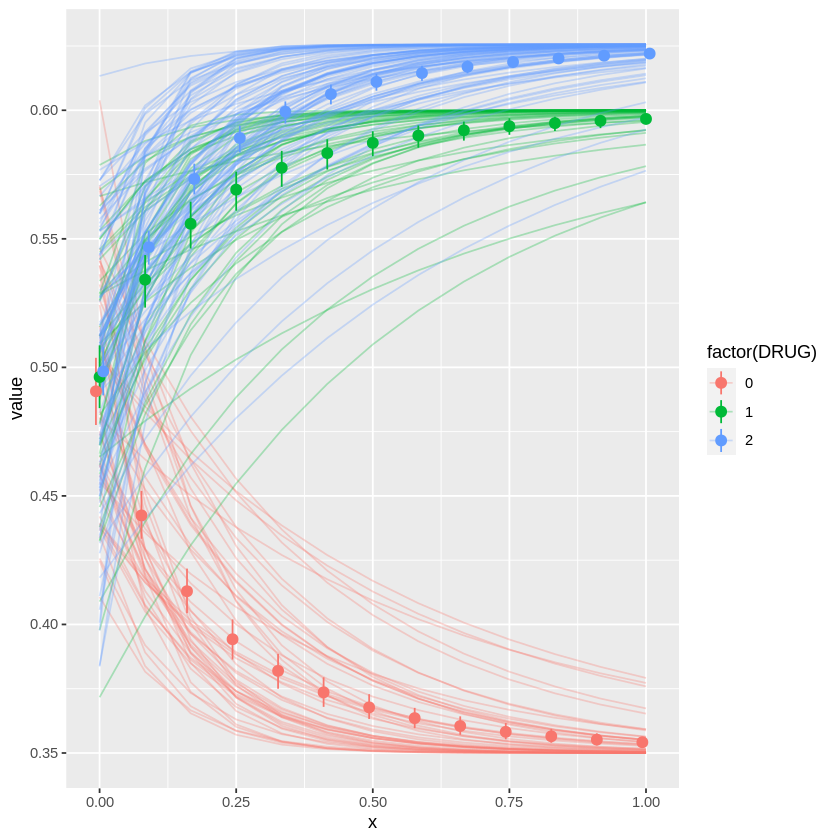

In [70]:
plm

In [71]:
## create noise which we recycle for all of the different delta
## simulations
y_err       <- matrix(rnorm(J*T,             0, sigma_y), J,       T)
y_prime_err <- matrix(rnorm(J_prime*T_prime, 0, sigma_y), J_prime, T_prime)
y           <- ysim       + y_err
y_prime <- ysim_prime + y_prime_err

In [72]:
y_prime_bar <- colMeans(y_prime)